In [1]:
%load_ext autoreload
%autoreload 2

import pathlib
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import pandas as pd
pd.set_option('display.max_rows', None)

import numpy as np

from typing import List, Dict

plt.rcParams["font.size"] = "15"
matplotlib.rc('figure', figsize=[6,4])

from data_handlers.runtimes import *
from data_handlers.preprocessors import node_types

In [2]:
def progress_bar(current, maximum):
    executed_percent = int(round((current / maximum) * 100))
    print(f"\r[", end="")
    print(f"#" * executed_percent, end="")
    print(f"_" * (100 - executed_percent), end="")
    print(f"]", end="")
    
    if executed_percent == 100:
        print(f" Done", end="")
    else:
        print(f" {executed_percent}%", end="")

# Parse Experiments

In [3]:
experiment_path = pathlib.Path(f"/home/jovyan/work/binary_files/8/")

In [4]:
event_frame: pd.DataFrame
event_frame = parse_bundle_events(experiment_path)

Parsing /home/jovyan/work/binary_files/8/ids/36
Parsing /home/jovyan/work/binary_files/8/ids/37
Parsing /home/jovyan/work/binary_files/8/ids/38
Parsing /home/jovyan/work/binary_files/8/ids/39
Parsing /home/jovyan/work/binary_files/8/ids/40
Parsing /home/jovyan/work/binary_files/8/ids/41
Parsing /home/jovyan/work/binary_files/8/ids/42
Parsing /home/jovyan/work/binary_files/8/ids/43
Parsing /home/jovyan/work/binary_files/8/ids/44
Parsing /home/jovyan/work/binary_files/8/ids/45
Parsing /home/jovyan/work/binary_files/8/ids/46
Parsing /home/jovyan/work/binary_files/8/ids/47
Parsing /home/jovyan/work/binary_files/8/ids/48
Parsing /home/jovyan/work/binary_files/8/ids/49
Parsing /home/jovyan/work/binary_files/8/ids/50
Parsing /home/jovyan/work/binary_files/8/ids/51
Parsing /home/jovyan/work/binary_files/8/ids/52
Parsing /home/jovyan/work/binary_files/8/ids/53
Parsing /home/jovyan/work/binary_files/8/ids/54
Parsing /home/jovyan/work/binary_files/8/ids/55
Parsing /home/jovyan/work/binary_files/8

In [5]:
types = node_types(scenario_path="/home/jovyan/work/scenarios/wanderwege/wanderwege.xml")
type_frame = pd.DataFrame(types.items(), columns=["node", "node_type"])

In [6]:
event_frame = event_frame.merge(type_frame, how="left", on="node")

# Compute and plot Total Number of Forwards

In [7]:
def bundle_distribution(event_frame: pd.DataFrame) -> DataFrame:
    simulation_data = event_frame.set_index("timestamp")
    instances = simulation_data[simulation_data.event == "reception"].groupby("sim_instance_id")
    runtimes = []
    
    big_fat_dataframe = DataFrame()
    for _, instance in instances:
        simulation_start = instance.index[0]
        instance["since_start"] = instance.index - simulation_start
        instance = instance.set_index("since_start")
        new_bundles = instance.groupby(pd.Grouper(freq='1Min')).apply(len).to_frame()
        new_bundles = new_bundles.rename(columns={0: "reception_count"})
        
        while len(new_bundles) <= 60:
            new_bundles = new_bundles.append({"reception_count": 0}, ignore_index=True)
        
        new_bundles["sim_instance_id"] = instance["sim_instance_id"][0]
        new_bundles["routing"] = instance["routing"][0]
        new_bundles["reception_accumulated"] = new_bundles["reception_count"].cumsum()
        
        new_bundles.loc[new_bundles['routing'] == 'epidemic', 'routing'] = 'Epidemic'
        new_bundles.loc[new_bundles['routing'] == 'binary_spray', 'routing'] = 'Binary Spray & Wait'
        new_bundles.loc[new_bundles['routing'] == 'prophet', 'routing'] = 'Prophet'
        new_bundles.loc[new_bundles['routing'] == 'dtlsr', 'routing'] = 'DTLSR'
        new_bundles.loc[new_bundles['routing'] == 'context_epidemic', 'routing'] = 'Software Defined\nEpidemic'
        new_bundles.loc[new_bundles['routing'] == 'context_spray', 'routing'] = 'Software Defined\nBinary Spray & Wait'
        new_bundles.loc[new_bundles['routing'] == 'context_complex', 'routing'] = 'Software Defined Complex'
        
        big_fat_dataframe = big_fat_dataframe.append(new_bundles)
        
    return big_fat_dataframe
        

big_fat_dataframe = bundle_distribution(event_frame)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


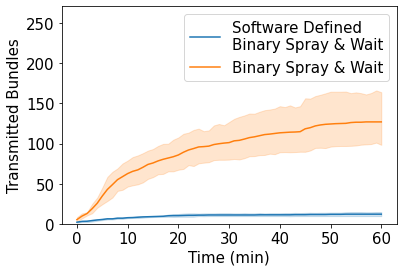

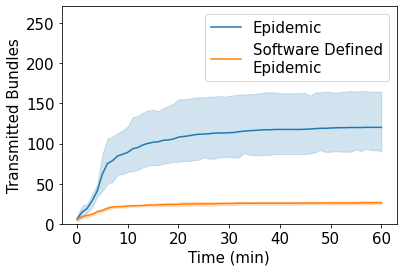

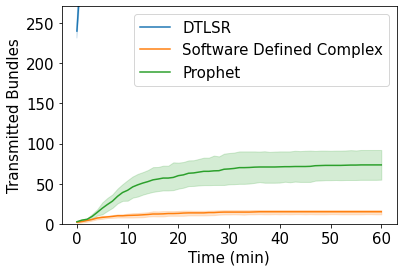

In [8]:
def plot_accumulated(groups):
    cleared_df = big_fat_dataframe[big_fat_dataframe['routing'].isin(groups)]
    
    ax = sns.lineplot(
        x=cleared_df.index,
        y='reception_accumulated',
        data=cleared_df,
        hue="routing",
        legend="full",
    )
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    
    ax.set(xlabel='Time (min)', ylabel='Transmitted Bundles', ylim=[0,271])

    plt.show()

groups = [
    ["Binary Spray & Wait", "Software Defined\nBinary Spray & Wait"],
    ["Epidemic", "Software Defined\nEpidemic"],
    ["Prophet", "DTLSR", "Software Defined Complex"],
]

for group in groups:
    plot_accumulated(group)

# Compute and plot Average End-to-End Delay

In [10]:
def bundle_runtimes(event_frame: pd.DataFrame) -> DataFrame:
    simulation_data = event_frame #.set_index("timestamp")
    creation_instances = simulation_data[simulation_data.event == "creation"]
    
    delivery_instances = simulation_data[simulation_data.event == "delivery"].groupby(["sim_instance_id", "bundle"])
    
    big_fat_dataframe = pd.DataFrame()
    _len = len(delivery_instances)
    i = 0
    for name, instance in delivery_instances:
        progress_bar(i, _len)
        i += 1
        
        sim_instance_id, bundle = name
        
        instance = instance.sort_values("timestamp")
        delivery_row = instance.iloc[0]
        delivery_time = delivery_row["timestamp"]
        
        creation_row = creation_instances[creation_instances.bundle == bundle]
        if creation_row.empty: # TODO: Remove, after context bundles are ignored!
            continue
        creation_time = creation_row["timestamp"].iloc[0]
        runtime = delivery_time - creation_time
        if runtime < pd.Timedelta(100,'ms'):
            continue
        
        runtime_dict = {
            "sim_instance_id": sim_instance_id,
            "bundle": bundle,
            "runtime": (runtime.to_pytimedelta() / timedelta(milliseconds=1)) / 1000,
            "routing": creation_row["routing"].values[0]
        }
        
        big_fat_dataframe = big_fat_dataframe.append(runtime_dict, ignore_index=True)
        
    big_fat_dataframe.loc[big_fat_dataframe['routing'] == 'epidemic', 'routing'] = 'Epidemic'
    big_fat_dataframe.loc[big_fat_dataframe['routing'] == 'binary_spray', 'routing'] = 'Binary Spray & Wait'
    big_fat_dataframe.loc[big_fat_dataframe['routing'] == 'prophet', 'routing'] = 'Prophet'
    big_fat_dataframe.loc[big_fat_dataframe['routing'] == 'dtlsr', 'routing'] = 'DTLSR'
    big_fat_dataframe.loc[big_fat_dataframe['routing'] == 'context_epidemic', 'routing'] = 'Software Defined\nEpidemic'
    big_fat_dataframe.loc[big_fat_dataframe['routing'] == 'context_spray', 'routing'] = 'Software Defined\nBinary Spray & Wait'
    big_fat_dataframe.loc[big_fat_dataframe['routing'] == 'context_complex', 'routing'] = 'Software Defined Complex'
    
    return big_fat_dataframe

runtimes = bundle_runtimes(event_frame)

[####################################################################################################] Done#_________________________________________________________________________________________________] 3%#####_______________________________________________________________________________________________] 5%] 13%######################______________________________________________________________________________] 22%#######################_____________________________________________________________________________] 23%#########################___________________________________________________________________________] 25%__________________________________________________________________________] 26%############################________________________________________________________________________] 28%#############################_______________________________________________________________________] 29%###################################___________________________________________

[Text(0, 0, 'Epidemic'),
 Text(0, 0, 'DTLSR'),
 Text(0, 0, 'Software Defined\nEpidemic'),
 Text(0, 0, 'Software Defined\nBinary Spray & Wait'),
 Text(0, 0, 'Software Defined Complex'),
 Text(0, 0, 'Prophet'),
 Text(0, 0, 'Binary Spray & Wait')]

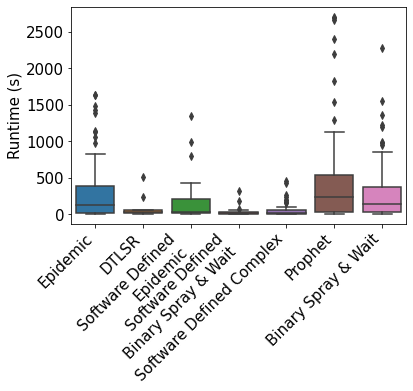

In [11]:
ax = sns.boxplot(x="routing", y="runtime", data=runtimes)
ax.set(xlabel='', ylabel='Runtime (s)')
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
)

In [12]:
def bundles_delivered(event_frame: pd.DataFrame) -> DataFrame:
    creation_instances = event_frame[event_frame.event == "creation"].groupby(["sim_instance_id"])
    
    delivery_instances = event_frame[event_frame.event == "delivery"]
    
    big_fat_dataframe = pd.DataFrame()
    for sim_instance_id, instance in creation_instances:
        for _, row in instance.iterrows():
            bundle = row["bundle"]
            was_delivered = not delivery_instances[delivery_instances["bundle"] == bundle].empty
            row_dict = {
                "sim_instance_id": sim_instance_id,
                "bundle": bundle,
                "delivered": was_delivered,
                "routing": row["routing"]
            }
            big_fat_dataframe = big_fat_dataframe.append([row_dict], ignore_index=True)
            
    return big_fat_dataframe   

In [14]:
delivery_df = bundles_delivered(event_frame)

In [15]:
def delivery_percentage(big_fat_dataframe) -> DataFrame:
    small_dataframe = pd.DataFrame()
    for name, bundles in big_fat_dataframe.groupby(["routing", "sim_instance_id"]):
        routing, sim_instance_id = name
        total_bundles = len(bundles.index)
        delivered_bundles = len(bundles[bundles.delivered == True].index)
        row_dict = {
            "routing": routing,
            "sim_instance_id": sim_instance_id,
            "delivery_percentage": (float(delivered_bundles) / float(total_bundles)) * 100
        }
        small_dataframe = small_dataframe.append([row_dict], ignore_index=True)
        
    small_dataframe.loc[small_dataframe['routing'] == 'epidemic', 'routing'] = 'Epidemic'
    small_dataframe.loc[small_dataframe['routing'] == 'binary_spray', 'routing'] = 'Binary Spray & Wait'
    small_dataframe.loc[small_dataframe['routing'] == 'prophet', 'routing'] = 'Prophet'
    small_dataframe.loc[small_dataframe['routing'] == 'dtlsr', 'routing'] = 'DTLSR'
    small_dataframe.loc[small_dataframe['routing'] == 'context_epidemic', 'routing'] = 'Software Defined\nEpidemic'
    small_dataframe.loc[small_dataframe['routing'] == 'context_spray', 'routing'] = 'Software Defined\nBinary Spray & Wait'
    small_dataframe.loc[small_dataframe['routing'] == 'context_complex', 'routing'] = 'Software Defined Complex'
    
    return small_dataframe

In [16]:
delivery_percentage_df = delivery_percentage(delivery_df)

[Text(0, 0, 'Binary Spray & Wait'),
 Text(0, 0, 'Software Defined Complex'),
 Text(0, 0, 'Software Defined\nEpidemic'),
 Text(0, 0, 'Software Defined\nBinary Spray & Wait'),
 Text(0, 0, 'DTLSR'),
 Text(0, 0, 'Epidemic'),
 Text(0, 0, 'Prophet')]

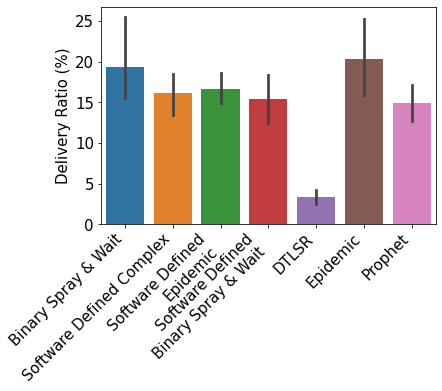

In [17]:
ax = sns.barplot(x="routing", y="delivery_percentage", data=delivery_percentage_df)
ax.set(xlabel='', ylabel='Delivery Ratio (%)')
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
)